# Getting SIFT Features

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import mahotas
import cv2
import os
import h5py
import argparse as ap
# Importing library that supports user friendly commandline interfaces
import cv2
# Importing the opencv library
import numpy as np
# Importing the array operations library for python
import os
# Importing the library which supports standard systems commands
from scipy.cluster.vq import *
# Importing the library which classifies set of observations into clusters
from sklearn.preprocessing import StandardScaler
# Importing the library that supports centering and scaling vectors
from sklearn.svm import LinearSVC
# Importing the svm library
from sklearn.externals import joblib
# Importing library that supports the functionality to save the dictionary
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def imlist(path):
    """
    The function imlist returns all the names of the files in 
    the directory path supplied as argument to the function.
    """
    return [os.path.join(path, f) for f in os.listdir(path)]

In [3]:
# fixed-sizes for image
fixed_size = tuple((500, 500))

# path to training data
train_path = "../dataset/train/"
training_names = os.listdir(train_path)

# no.of.trees for Random Forests
num_trees = 100

# bins for histogram
bins = 8

# train_test_split size
test_size = 0.45

# seed for reproducing same results
seed = 9

In [4]:
image_paths = []
image_classes = []
class_id = 0
for training_name in training_names:
    dir = os.path.join(train_path, training_name)
    class_path = imlist(dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [5]:
# Create feature extraction and keypoint detector objects
fea_det = cv2.xfeatures2d.SIFT_create()
# des_ext = cv2.DescriptorExtractor_create("SIFT")
surf = cv2.xfeatures2d.SURF_create()
orb = cv2.ORB_create(nfeatures=1500)
# brief = cv2.xfeatures2d.brief()
# List where all the descriptors are stored
des_list = []

error_count = 0
for image_path in image_paths:
    im = cv2.imread(image_path)
    try:
        (kps, des) = surf.detectAndCompute(im, None)
#         print des.shape, des2.shape, des3.shape
    except:
        print image_path
    if des is not None:
        des_list.append((image_path, des))
    else:
        print image_path
print "done"
# Stack all the descriptors vertically in a numpy array
descriptors = des_list[0][1]
for image_path, descriptor in des_list[1:]:
    descriptors = np.vstack((descriptors, descriptor))

done


In [6]:
# Perform k-means clustering
k = 100
voc, variance = kmeans(descriptors, k, 1)

# Calculate the histogram of features
im_features = np.zeros((len(image_paths), k), "float32")
for i in xrange(len(image_paths)):
    words, distance = vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w] += 1 # Caluculating the histogram of features

In [7]:
# Perform Tf-Idf vectorization
nbr_occurences = np.sum( (im_features > 0) * 1, axis = 0)
# Calculating the number of occurrences
idf = np.array(np.log((1.0*len(image_paths)+1) / (1.0*nbr_occurences + 1)), 'float32')
# Giving weight to one that occurs more frequently

# Scaling the words
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)  # Scaling the visual words for better Prediction

# Training Classifiers on the features

In [8]:
import h5py
import numpy as np
import os
import glob
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

/usr/local/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [9]:
models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=9)))

In [10]:
print "[STATUS] training started..."

# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(im_features),
                                                                                          np.array(image_classes),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print "[STATUS] splitted train and test data..."
print "Train data  : {}".format(trainDataGlobal.shape)
print "Test data   : {}".format(testDataGlobal.shape)
print "Train labels: {}".format(trainLabelsGlobal.shape)
print "Test labels : {}".format(testLabelsGlobal.shape)

# filter all the warnings
import warnings
warnings.filterwarnings('ignore')

[STATUS] training started...
[STATUS] splitted train and test data...
Train data  : (324, 100)
Test data   : (266, 100)
Train labels: (324,)
Test labels : (266,)


LR: 0.722064 (0.052678)
LDA: 0.675758 (0.067194)
KNN: 0.747064 (0.063922)
CART: 0.657860 (0.082106)
RF: 0.802557 (0.036662)
NB: 0.675568 (0.063464)
SVM: 0.811742 (0.037753)


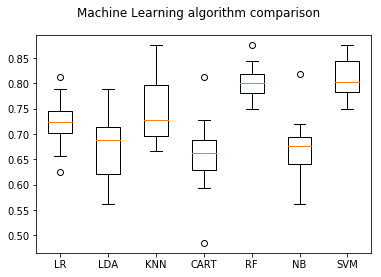

In [11]:
results = []
names = []

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=7)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()